# Recency Frequency Monetary (RFM)

After having cleaned the data and reduced some features I wanted to start with the analysis. I set the goal to cluster the different customers to receive new insights. I started with the following questions:
- Is there any significant difference between the customers of the different markets/countries. 
- There is loss/profit. How much profit did the store make in last few years?
- Which are the valuable customers and do they still order products from our store?

So those few questions lead me to the RFM concept that is build up by 3 factors:
- Recency: How recently a customer has made a purchase
- Frequency: How often a customer makes a purchase
- Monetary: How much money a customer spends on purchases
The RFM value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. 

### Import libaries and datasets

In [1]:

import numpy as np
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set()
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D



In [2]:
df=pd.read_csv('../csv/cleaned_csv.csv')

In [3]:
df.head()

,Date,Customer_ID,Customer_Name,Segment,City,Country,Market,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit,Shipping Cost,Sales_ohne_Discount
0,2011-01-01,TB-11280,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,408.30
1,2011-01-01,JH-15985,Joseph Holt,Consumer,Wagga Wagga,Australia,APAC,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,133.74
2,2011-01-01,AT-735,Annie Thurman,Consumer,Budapest,Hungary,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,66.12
3,2011-01-01,EM-14140,Eugene Moren,Home Office,Stockholm,Sweden,EU,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,89.73
4,2011-01-01,JH-15985,Joseph Holt,Consumer,Wagga Wagga,Australia,APAC,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,126.30


In [4]:
df.dtypes

Date                    object
Customer_ID             object
Customer_Name           object
Segment                 object
City                    object
Country                 object
Market                  object
Product_ID              object
Category                object
Sub_Category            object
Product_Name            object
Sales                  float64
Quantity                 int64
Discount               float64
Profit                 float64
Shipping Cost          float64
Sales_ohne_Discount    float64
dtype: object

## Frequency

The calculation of frequency is the easiest. Each order is one frequency. As we have not grouped the dataframe yet, we just give each order a 1.

In [5]:
df['Frequency']=np.where(df.Quantity>0,1,0)

### Monetary

The monetary factor is also easy as long as we have it split up by orders. At the moment each sales value is equal to the monetary. Thoungh once we group the dataframe by customer, the monetary factor will represent the total of all sales. 

In [6]:
df['Monetary']=df.Sales

## Recency

Recency is the most trickiest one. It represents how recent a customer has ordered something from the store. In case he ordered already a few times, we only take the most recent order date. As datetime is a difficult format we rather convert it to days. But firstwe need to convert the date into a datetime format, so we can subtract dates to receive the amount of days. 

In [7]:
from datetime import datetime as dt
df['Date']=pd.to_datetime(df['Date'])

What is the last date that was registered in the dataframe. It is the last day in 2014. Therefore we will take the 31st December 2014 as our last day in the timeframe. So we will subtract the most frequent order from that date to measure the recency. 

In [8]:
last_date=df.Date.max()
print(last_date)

2014-12-31 00:00:00


In [9]:
df.Date.min()

Timestamp('2011-01-01 00:00:00')

In [10]:
def recency_days(last_date,row):
    '''input: the date when the order was done, subtracting from the last date registered in the dataframe
    output: difference in days'''
    return abs((last_date - row['Date']).days)

In [11]:
df['Recency']=df.apply(lambda row:recency_days(last_date,row), axis=1)

In [12]:
df.head()

,Date,Customer_ID,Customer_Name,Segment,City,Country,Market,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit,Shipping Cost,Sales_ohne_Discount,Frequency,Monetary,Recency
0,2011-01-01,TB-11280,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,408.30,1,408.300,1460
1,2011-01-01,JH-15985,Joseph Holt,Consumer,Wagga Wagga,Australia,APAC,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,133.74,1,120.366,1460
2,2011-01-01,AT-735,Annie Thurman,Consumer,Budapest,Hungary,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,66.12,1,66.120,1460
3,2011-01-01,EM-14140,Eugene Moren,Home Office,Stockholm,Sweden,EU,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,89.73,1,44.865,1460
4,2011-01-01,JH-15985,Joseph Holt,Consumer,Wagga Wagga,Australia,APAC,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,126.30,1,113.670,1460


So we added the recency, frequency and monetary to the dataframe. Although before clustering the customers by RFM we will do the exploratory data analysis.

## Exploratory Data Analysis

In a first step we want to see how the business has developed in the last few years. Therefore we need to group the dataset by date-month. 

In [13]:
df.columns

Index(['Date', 'Customer_ID', 'Customer_Name', 'Segment', 'City', 'Country',
       'Market', 'Product_ID', 'Category', 'Sub_Category', 'Product_Name',
       'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost',
       'Sales_ohne_Discount', 'Frequency', 'Monetary', 'Recency'],
      dtype='object')

In [14]:
def monthly(x):
    return dt(x.year,x.month,1)
df['BillMonth']=df['Date'].apply(monthly)

In [15]:
df.head()

,Date,Customer_ID,Customer_Name,Segment,City,Country,Market,Product_ID,Category,Sub_Category,...,Sales,Quantity,Discount,Profit,Shipping Cost,Sales_ohne_Discount,Frequency,Monetary,Recency,BillMonth
0,2011-01-01,TB-11280,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,OFF-TEN-10000025,Office Supplies,Storage,...,408.300,2,0.0,106.140,35.46,408.30,1,408.300,1460,2011-01-01
1,2011-01-01,JH-15985,Joseph Holt,Consumer,Wagga Wagga,Australia,APAC,OFF-SU-10000618,Office Supplies,Supplies,...,120.366,3,0.1,36.036,9.72,133.74,1,120.366,1460,2011-01-01
2,2011-01-01,AT-735,Annie Thurman,Consumer,Budapest,Hungary,EMEA,OFF-TEN-10001585,Office Supplies,Storage,...,66.120,4,0.0,29.640,8.17,66.12,1,66.120,1460,2011-01-01
3,2011-01-01,EM-14140,Eugene Moren,Home Office,Stockholm,Sweden,EU,OFF-PA-10001492,Office Supplies,Paper,...,44.865,3,0.5,-26.055,4.82,89.73,1,44.865,1460,2011-01-01
4,2011-01-01,JH-15985,Joseph Holt,Consumer,Wagga Wagga,Australia,APAC,FUR-FU-10003447,Furniture,Furnishings,...,113.670,5,0.1,37.770,4.70,126.30,1,113.670,1460,2011-01-01


In [16]:
date_profit=df.groupby('BillMonth', as_index=False).agg({'Profit':'sum'})
date_profit.columns

Index(['BillMonth', 'Profit'], dtype='object')

/Users/kforster/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


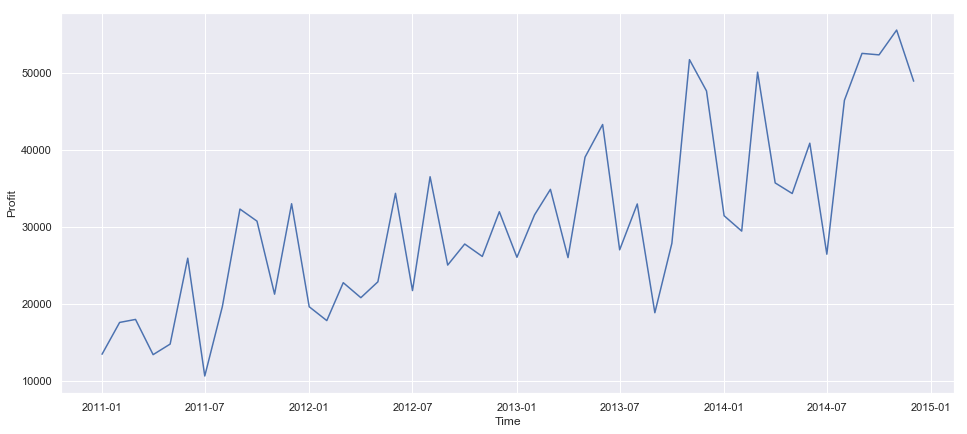

In [17]:
plt.figure(figsize=(16,7))
sns.lineplot(x=date_profit.BillMonth, y=date_profit.Profit)
plt.xlabel('Time')
plt.show()

Text(0.5, 1.0, 'Most Selling 20 Products')

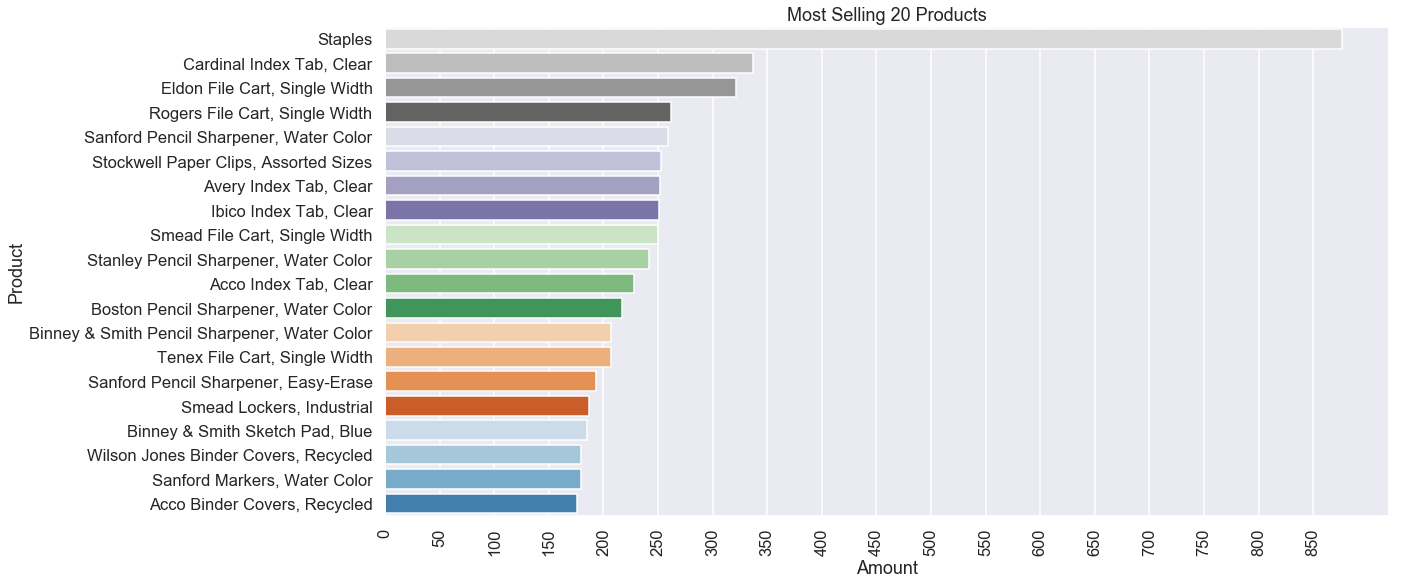

In [18]:
most_selling_products=df.groupby('Product_Name', as_index=False).agg({'Quantity':'sum'}).sort_values(by='Quantity', ascending=False).head(20)
plt.figure(figsize=(18,9))
sns.set_context('talk')
sns.barplot(x=most_selling_products.Quantity,y=most_selling_products.Product_Name, palette="tab20c_r")
plt.xticks(np.arange(0,900,50),rotation = 90)
plt.xlabel("Amount")
plt.ylabel("Product")
plt.title("Most Selling 20 Products")

## Cohort analysis

In [19]:
g=df.groupby('Customer_ID')['BillMonth']
df['CohortMonth']=g.transform('min')
df.head()

,Date,Customer_ID,Customer_Name,Segment,City,Country,Market,Product_ID,Category,Sub_Category,...,Quantity,Discount,Profit,Shipping Cost,Sales_ohne_Discount,Frequency,Monetary,Recency,BillMonth,CohortMonth
0,2011-01-01,TB-11280,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,OFF-TEN-10000025,Office Supplies,Storage,...,2,0.0,106.140,35.46,408.30,1,408.300,1460,2011-01-01,2011-01-01
1,2011-01-01,JH-15985,Joseph Holt,Consumer,Wagga Wagga,Australia,APAC,OFF-SU-10000618,Office Supplies,Supplies,...,3,0.1,36.036,9.72,133.74,1,120.366,1460,2011-01-01,2011-01-01
2,2011-01-01,AT-735,Annie Thurman,Consumer,Budapest,Hungary,EMEA,OFF-TEN-10001585,Office Supplies,Storage,...,4,0.0,29.640,8.17,66.12,1,66.120,1460,2011-01-01,2011-01-01
3,2011-01-01,EM-14140,Eugene Moren,Home Office,Stockholm,Sweden,EU,OFF-PA-10001492,Office Supplies,Paper,...,3,0.5,-26.055,4.82,89.73,1,44.865,1460,2011-01-01,2011-01-01
4,2011-01-01,JH-15985,Joseph Holt,Consumer,Wagga Wagga,Australia,APAC,FUR-FU-10003447,Furniture,Furnishings,...,5,0.1,37.770,4.70,126.30,1,113.670,1460,2011-01-01,2011-01-01


In [20]:
df.CohortMonth.value_counts()

2011-01-01    11660
2011-03-01     7551
2011-02-01     7029
2011-04-01     4676
2011-06-01     4079
2011-05-01     3962
2011-08-01     2450
2011-07-01     2254
2011-09-01     1750
2011-10-01     1211
2011-11-01      962
2011-12-01      653
2012-06-01      311
2012-01-01      289
2012-02-01      289
2012-03-01      282
2012-09-01      255
2012-08-01      212
2012-07-01      176
2012-11-01      170
2012-05-01      145
2012-04-01      133
2012-12-01      126
2012-10-01       90
2013-01-01       81
2013-03-01       76
2013-06-01       62
2013-02-01       58
2013-04-01       55
2013-08-01       43
2014-01-01       27
2013-05-01       21
2013-12-01       20
2013-07-01       19
2014-02-01       19
2013-09-01       17
2014-07-01       15
2013-10-01       15
2014-06-01       14
2014-05-01       11
2014-04-01        8
2014-10-01        6
2014-03-01        5
2013-11-01        2
Name: CohortMonth, dtype: int64

In [21]:
def get_int (df,column):
    year=df[column].dt.year
    month=df[column].dt.month
    return year, month

billYear, billMonth=get_int(df,'BillMonth')
cohortYear, cohortMonth = get_int(df,'CohortMonth')

diffYear=billYear - cohortYear
diffMonth=billMonth-cohortMonth

df['Month_index']=diffYear *12+diffMonth+1
df.head()



,Date,Customer_ID,Customer_Name,Segment,City,Country,Market,Product_ID,Category,Sub_Category,...,Discount,Profit,Shipping Cost,Sales_ohne_Discount,Frequency,Monetary,Recency,BillMonth,CohortMonth,Month_index
0,2011-01-01,TB-11280,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,OFF-TEN-10000025,Office Supplies,Storage,...,0.0,106.140,35.46,408.30,1,408.300,1460,2011-01-01,2011-01-01,1
1,2011-01-01,JH-15985,Joseph Holt,Consumer,Wagga Wagga,Australia,APAC,OFF-SU-10000618,Office Supplies,Supplies,...,0.1,36.036,9.72,133.74,1,120.366,1460,2011-01-01,2011-01-01,1
2,2011-01-01,AT-735,Annie Thurman,Consumer,Budapest,Hungary,EMEA,OFF-TEN-10001585,Office Supplies,Storage,...,0.0,29.640,8.17,66.12,1,66.120,1460,2011-01-01,2011-01-01,1
3,2011-01-01,EM-14140,Eugene Moren,Home Office,Stockholm,Sweden,EU,OFF-PA-10001492,Office Supplies,Paper,...,0.5,-26.055,4.82,89.73,1,44.865,1460,2011-01-01,2011-01-01,1
4,2011-01-01,JH-15985,Joseph Holt,Consumer,Wagga Wagga,Australia,APAC,FUR-FU-10003447,Furniture,Furnishings,...,0.1,37.770,4.70,126.30,1,113.670,1460,2011-01-01,2011-01-01,1


In [22]:
df['CohortMonth']=df['CohortMonth'].apply(dt.date)



In [23]:
g=df.groupby(['CohortMonth','Month_index'])

cohortData=g['Customer_ID'].apply(pd.Series.nunique).reset_index()
cohortCounts=cohortData.pivot(index='CohortMonth', columns='Month_index', values='Customer_ID')
cohortSizes=cohortCounts.iloc[:,0]
retention=cohortCounts.divide(cohortSizes,axis=0)*100

retention.round(2)

Month_index,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2011-01-01,100.0,21.80,28.95,23.31,21.05,28.20,27.44,26.32,31.58,27.07,...,38.72,38.72,37.59,45.11,36.84,43.98,47.74,52.63,50.75,52.63
2011-02-01,100.0,23.64,23.03,23.64,33.33,17.58,25.45,27.88,25.45,31.52,...,36.36,43.64,47.88,35.15,51.52,51.52,45.45,52.73,44.85,NaN
2011-03-01,100.0,20.43,14.52,28.49,19.89,25.27,31.18,26.88,30.65,36.02,...,39.78,47.85,34.41,40.86,51.08,39.78,50.00,51.61,NaN,NaN
2011-04-01,100.0,20.80,24.00,24.80,22.40,29.60,27.20,26.40,32.00,14.40,...,52.00,25.60,36.00,32.80,46.40,42.40,41.60,NaN,NaN,NaN
2011-05-01,100.0,25.24,18.45,32.04,28.16,23.30,28.16,27.18,20.39,23.30,...,23.30,42.72,40.78,36.89,50.49,50.49,NaN,NaN,NaN,NaN
2011-06-01,100.0,26.05,21.01,29.41,15.97,26.89,28.57,14.29,17.65,26.89,...,42.02,36.97,47.06,47.90,41.18,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.75,20.31,28.12,26.56,29.69,10.94,15.62,25.00,20.31,...,35.94,37.50,45.31,48.44,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,21.18,18.82,20.00,17.65,17.65,17.65,16.47,21.18,23.53,...,36.47,42.35,42.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,100.0,16.00,18.67,21.33,13.33,9.33,13.33,12.00,18.67,24.00,...,33.33,33.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


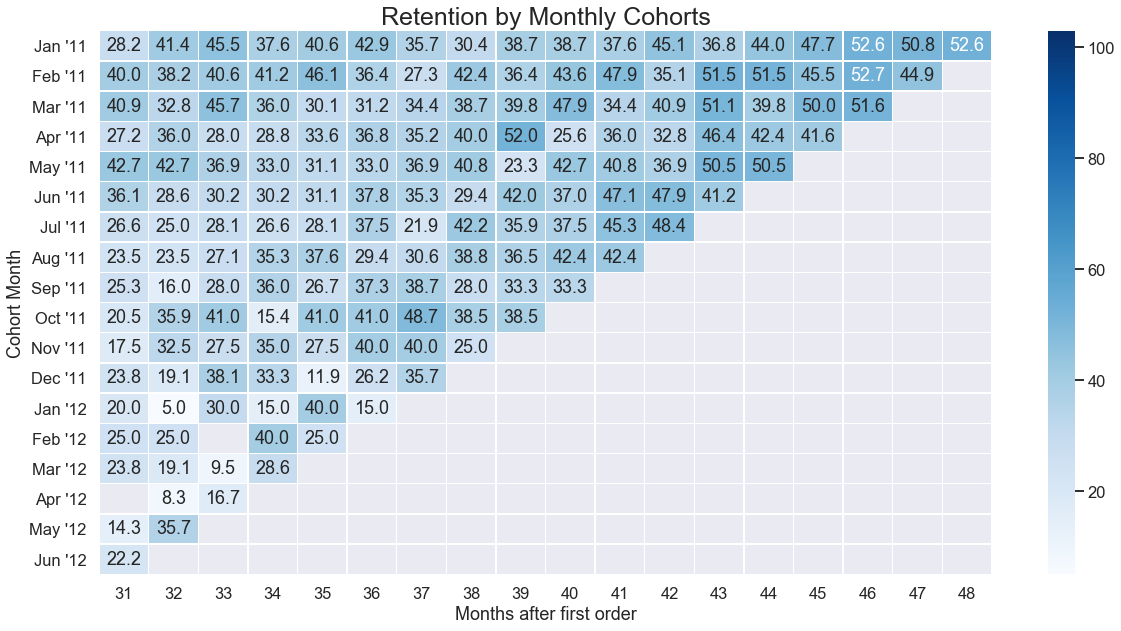

In [24]:
month_list = ["Jan '11", "Feb '11", "Mar '11", "Apr '11", "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", "Oct '11", "Nov '11", "Dec '11","Jan '12", "Feb '12", "Mar '12", "Apr '12", "May '12", "Jun '12"]
plt.figure(figsize=(20,10))
plt.title('Retention by Monthly Cohorts',size=25)
sns.heatmap(retention.iloc[:18,30:].round(2),annot=True, cmap='Blues',vmax=list(retention.max().sort_values(ascending=False))[1]+3, fmt='.1f', linewidth = 0.3,yticklabels=month_list)
plt.ylabel('Cohort Month')
plt.xlabel('Months after first order')
plt.show()

## Cohort analysis EMEA

In [25]:
df_market=df[df.Market=='EMEA']

In [26]:
g=df_market.groupby('Customer_ID')['BillMonth']
df_market['CohortMonth']=g.transform('min')
df_market.head()

def get_int (df_market,column):
    year=df_market[column].dt.year
    month=df_market[column].dt.month
    return year, month

billYear, billMonth=get_int(df_market,'BillMonth')
cohortYear, cohortMonth = get_int(df_market,'CohortMonth')

diffYear=billYear - cohortYear
diffMonth=billMonth-cohortMonth

df_market['Month_index']=diffYear *12+diffMonth+1
df_market.head()


/Users/kforster/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kforster/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Date,Customer_ID,Customer_Name,Segment,City,Country,Market,Product_ID,Category,Sub_Category,...,Discount,Profit,Shipping Cost,Sales_ohne_Discount,Frequency,Monetary,Recency,BillMonth,CohortMonth,Month_index
2,2011-01-01,AT-735,Annie Thurman,Consumer,Budapest,Hungary,EMEA,OFF-TEN-10001585,Office Supplies,Storage,...,0.0,29.64,8.17,66.12,1,66.12,1460,2011-01-01,2011-01-01,1
12,2011-01-02,PO-8850,Patrick O'Brill,Consumer,Mashhad,Iran,EMEA,FUR-ADV-10002601,Furniture,Furnishings,...,0.0,148.50,19.65,309.60,1,309.60,1459,2011-01-01,2011-01-01,1
25,2011-01-03,RD-9900,Ruben Dartt,Consumer,Vinnytsya,Ukraine,EMEA,TEC-LOG-10003896,Technology,Accessories,...,0.0,264.60,146.55,1470.78,1,1470.78,1458,2011-01-01,2011-01-01,1
30,2011-01-03,RD-9900,Ruben Dartt,Consumer,Vinnytsya,Ukraine,EMEA,OFF-FEL-10002867,Office Supplies,Storage,...,0.0,211.50,60.78,1244.16,1,1244.16,1458,2011-01-01,2011-01-01,1
33,2011-01-03,RD-9900,Ruben Dartt,Consumer,Vinnytsya,Ukraine,EMEA,TEC-SHA-10004874,Technology,Copiers,...,0.0,123.36,42.88,587.70,1,587.70,1458,2011-01-01,2011-01-01,1


In [27]:
df_market['CohortMonth']=df_market['CohortMonth'].apply(dt.date)


/Users/kforster/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
g=df_market.groupby(['CohortMonth','Month_index'])

cohortData=g['Customer_ID'].apply(pd.Series.nunique).reset_index()
cohortCounts=cohortData.pivot(index='CohortMonth', columns='Month_index', values='Customer_ID')
cohortSizes=cohortCounts.iloc[:,0]
retention=cohortCounts.divide(cohortSizes,axis=0)*100

g=df_market.groupby(['CohortMonth','Month_index'])

cohortData=g['Customer_ID'].apply(pd.Series.nunique).reset_index()
cohortCounts=cohortData.pivot(index='CohortMonth', columns='Month_index', values='Customer_ID')
cohortSizes=cohortCounts.iloc[:,0]
retention=cohortCounts.divide(cohortSizes,axis=0)*100

retention.round(2)

Month_index,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2011-01-01,100.0,3.45,3.45,3.45,NaN,13.79,6.90,3.45,NaN,3.45,...,NaN,10.34,6.90,10.34,13.79,24.14,13.79,10.34,10.34,3.45
2011-02-01,100.0,NaN,NaN,NaN,10.00,NaN,10.00,10.00,5.00,NaN,...,5.00,30.00,15.00,5.00,NaN,15.00,15.00,NaN,15.00,NaN
2011-03-01,100.0,13.79,NaN,3.45,NaN,10.34,NaN,3.45,NaN,6.90,...,3.45,6.90,3.45,10.34,10.34,6.90,3.45,17.24,NaN,NaN
2011-04-01,100.0,4.00,4.00,NaN,12.00,NaN,NaN,4.00,4.00,4.00,...,16.00,8.00,4.00,16.00,16.00,8.00,NaN,NaN,NaN,NaN
2011-05-01,100.0,NaN,NaN,NaN,NaN,4.17,8.33,4.17,12.50,8.33,...,8.33,4.17,20.83,NaN,4.17,20.83,NaN,NaN,NaN,NaN
2011-06-01,100.0,2.38,9.52,2.38,4.76,NaN,4.76,NaN,7.14,4.76,...,4.76,9.52,14.29,7.14,11.90,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,14.81,3.70,11.11,NaN,3.70,NaN,3.70,NaN,NaN,...,NaN,11.11,11.11,11.11,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,NaN,8.57,2.86,2.86,NaN,5.71,5.71,NaN,2.86,...,NaN,14.29,17.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,100.0,NaN,2.44,4.88,4.88,7.32,7.32,4.88,2.44,7.32,...,7.32,17.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


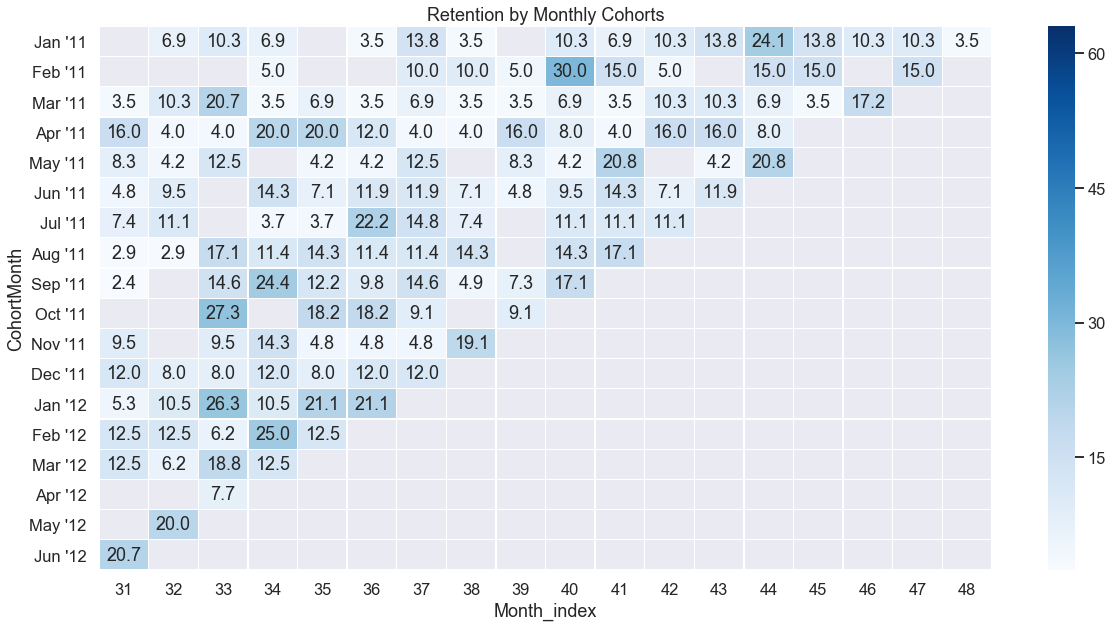

In [29]:
month_list = ["Jan '11", "Feb '11", "Mar '11", "Apr '11", "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", "Oct '11", "Nov '11", "Dec '11","Jan '12", "Feb '12", "Mar '12", "Apr '12", "May '12", "Jun '12"]
plt.figure(figsize=(20,10))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(retention.iloc[:18,30:].round(2),annot=True, cmap='Blues',vmax=list(retention.max().sort_values(ascending=False))[1]+3, fmt='.1f', linewidth = 0.3,yticklabels=month_list)
plt.show()

## RFM

In [30]:
df_RFM=df.groupby(['Customer_ID','Customer_Name'], as_index=False).agg({'Frequency':'sum','Recency':'min','Monetary':'sum','Profit':'sum'})
df_RFM2=df_RFM
df_RFM

,Customer_ID,Customer_Name,Frequency,Recency,Monetary,Profit
0,AA-10315,Alex Avila,42,8,13747.41300,447.69050
1,AA-10375,Allen Armold,42,6,5884.19500,677.47740
2,AA-10480,Andrew Allen,38,117,17695.58978,1516.47518
3,AA-10645,Anna Andreadi,73,26,15343.89070,3051.43900
4,AA-315,Alex Avila,8,2,2243.25600,535.56600
5,AA-375,Allen Armold,13,181,654.49200,77.44200
6,AA-480,Andrew Allen,10,314,2063.49300,554.61300
7,AA-645,Anna Andreadi,18,81,1968.32400,-608.34600
8,AB-10015,Aaron Bergman,77,16,20037.49750,3719.48800
9,AB-10060,Adam Bellavance,57,25,18416.55040,4514.05890


In [31]:
df_RFM['Frequency_qcut']=pd.qcut(df_RFM['Frequency'],q=5, labels = ['1','2','3','4','5'])


In [32]:
df_RFM['Recency_qcut']=pd.qcut(df_RFM['Recency'],q=5, labels = ['5','4','3','2','1'])
df_RFM['Monetary_qcut']=pd.qcut(df_RFM['Monetary'],q=5, labels = ['1','2','3','4','5'])


In [33]:
df_RFM.head()

,Customer_ID,Customer_Name,Frequency,Recency,Monetary,Profit,Frequency_qcut,Recency_qcut,Monetary_qcut
0,AA-10315,Alex Avila,42,8,13747.41300,447.69050,4,5,4
1,AA-10375,Allen Armold,42,6,5884.19500,677.47740,4,5,3
2,AA-10480,Andrew Allen,38,117,17695.58978,1516.47518,3,2,5
3,AA-10645,Anna Andreadi,73,26,15343.89070,3051.43900,5,4,5
4,AA-315,Alex Avila,8,2,2243.25600,535.56600,1,5,2


In [34]:
df_RFM['Frequency_qcut'] = pd.to_numeric(df_RFM['Frequency_qcut'])
df_RFM['Recency_qcut'] = pd.to_numeric(df_RFM['Recency_qcut'])
df_RFM['Monetary_qcut'] = pd.to_numeric(df_RFM['Monetary_qcut'])

In [35]:
df_RFM['Total_score']=df_RFM.Frequency_qcut+df_RFM.Monetary_qcut+df_RFM.Recency_qcut

In [36]:
df_RFM.head()

,Customer_ID,Customer_Name,Frequency,Recency,Monetary,Profit,Frequency_qcut,Recency_qcut,Monetary_qcut,Total_score
0,AA-10315,Alex Avila,42,8,13747.41300,447.69050,4,5,4,13
1,AA-10375,Allen Armold,42,6,5884.19500,677.47740,4,5,3,12
2,AA-10480,Andrew Allen,38,117,17695.58978,1516.47518,3,2,5,10
3,AA-10645,Anna Andreadi,73,26,15343.89070,3051.43900,5,4,5,14
4,AA-315,Alex Avila,8,2,2243.25600,535.56600,1,5,2,8


In [37]:
df_RFM.max()

Customer_ID                 ZD-21925
Customer_Name     Zuschuss Donatelli
Frequency                         97
Recency                         1118
Monetary                     35668.1
Profit                       8787.47
Frequency_qcut                     5
Recency_qcut                       5
Monetary_qcut                      5
Total_score                       15
dtype: object

Text(0.5, 0, 'Total sales in $')

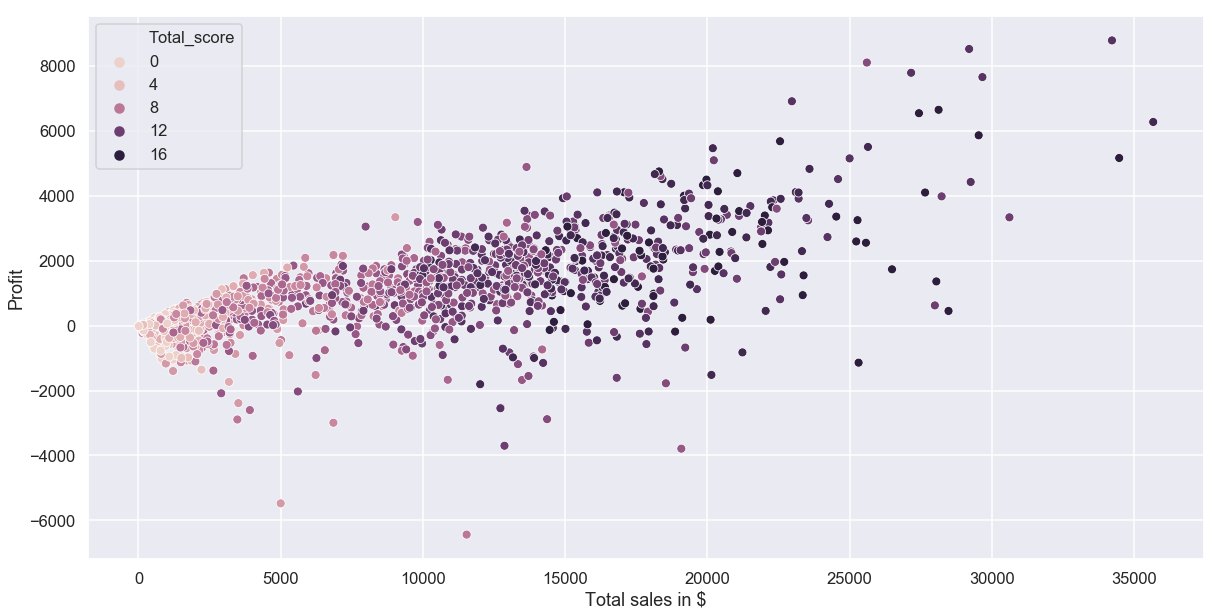

In [38]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=df_RFM.Monetary, y=df_RFM.Profit, hue=df_RFM.Total_score)
plt.xlabel('Total sales in $')

Text(0.5, 0, 'Frequency')

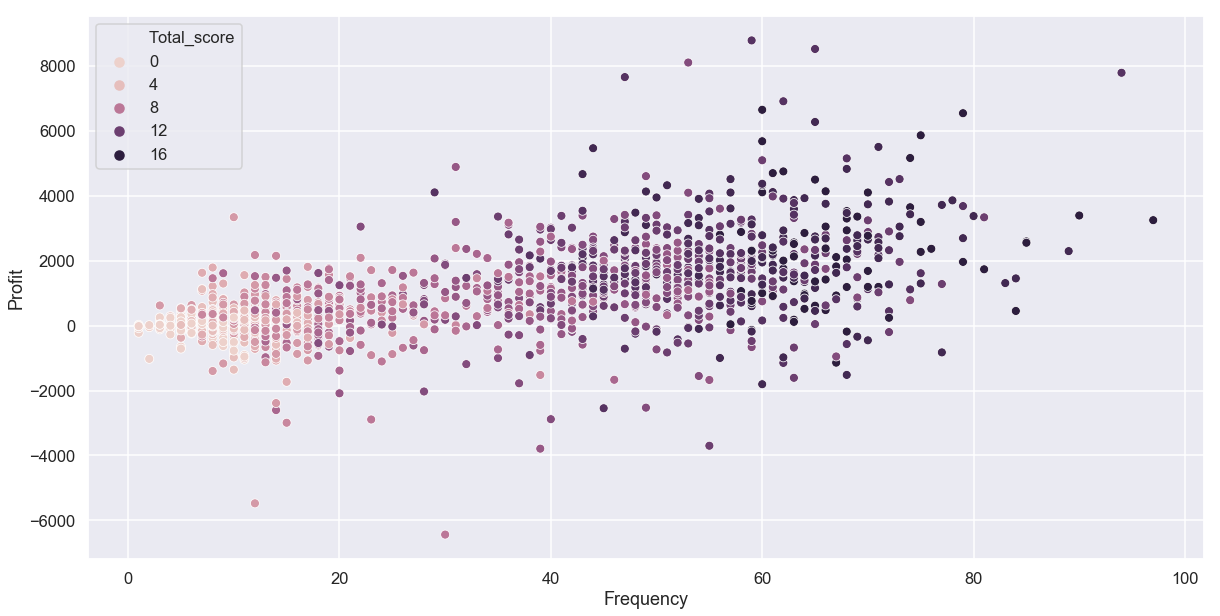

In [39]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=df_RFM.Frequency, y=df_RFM.Profit, hue=df_RFM.Total_score)
plt.xlabel('Frequency')

In [40]:
df_RFM.drop(['Total_score','Customer_Name', 'Frequency', 'Recency', 'Monetary','Profit'], axis=1, inplace=True)


In [41]:
df_RFM.set_index('Customer_ID',inplace=True)

In [42]:
df_RFM.dtypes

Frequency_qcut    int64
Recency_qcut      int64
Monetary_qcut     int64
dtype: object

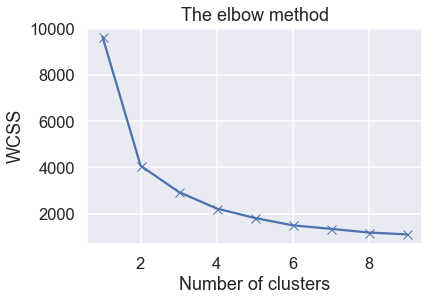

In [43]:
wcss = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_RFM)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 10), wcss, 'bx-')
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [44]:
kmeans = KMeans(n_clusters=3).fit(df_RFM)
df_RFM['label'] = kmeans.fit_predict(df_RFM)

In [45]:
df_RFM

,Frequency_qcut,Recency_qcut,Monetary_qcut,label
Customer_ID,,,,
AA-10315,4,5,4,1
AA-10375,4,5,3,1
AA-10480,3,2,5,1
AA-10645,5,4,5,1
AA-315,1,5,2,0
AA-375,2,1,1,2
AA-480,1,1,2,2
AA-645,3,2,2,2
AB-10015,5,4,5,1


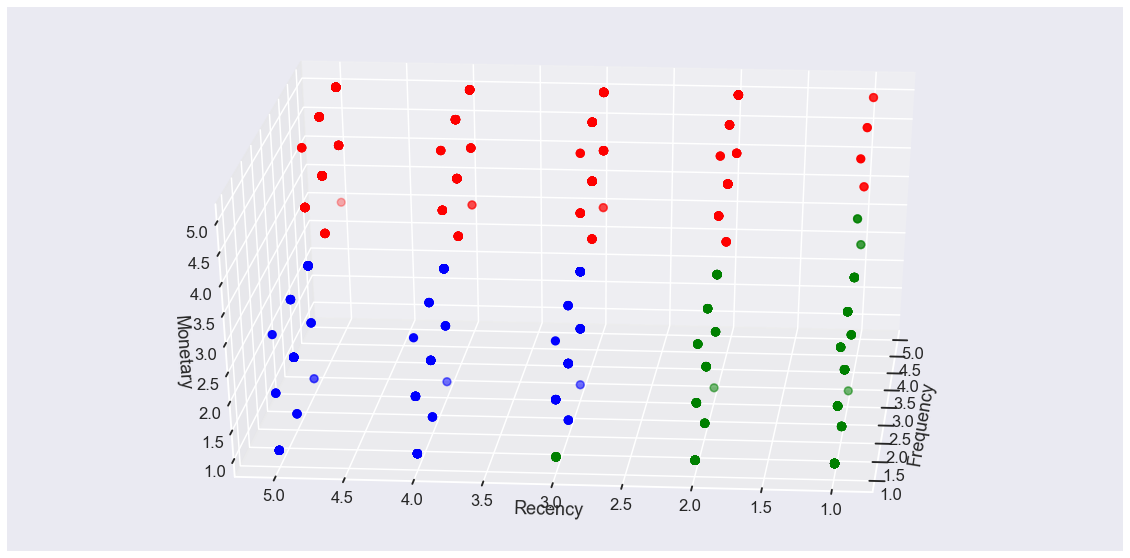

In [46]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_RFM.Frequency_qcut[df_RFM.label == 0], df_RFM["Recency_qcut"][df_RFM.label == 0], df_RFM["Monetary_qcut"][df_RFM.label == 0], c='blue', s=60)
ax.scatter(df_RFM.Frequency_qcut[df_RFM.label == 1], df_RFM["Recency_qcut"][df_RFM.label == 1], df_RFM["Monetary_qcut"][df_RFM.label == 1], c='red', s=60)
ax.scatter(df_RFM.Frequency_qcut[df_RFM.label == 2], df_RFM["Recency_qcut"][df_RFM.label == 2], df_RFM["Monetary_qcut"][df_RFM.label == 2], c='green', s=60)
ax.view_init(30, 185)
plt.xlabel("Frequency")
plt.ylabel("Recency")
ax.set_zlabel('Monetary')
plt.show()

In [47]:
df_RFM.reset_index(inplace=True)
df_RFM

,Customer_ID,Frequency_qcut,Recency_qcut,Monetary_qcut,label
0,AA-10315,4,5,4,1
1,AA-10375,4,5,3,1
2,AA-10480,3,2,5,1
3,AA-10645,5,4,5,1
4,AA-315,1,5,2,0
5,AA-375,2,1,1,2
6,AA-480,1,1,2,2
7,AA-645,3,2,2,2
8,AB-10015,5,4,5,1
9,AB-10060,5,4,5,1


In [48]:
df.dtypes

Date                   datetime64[ns]
Customer_ID                    object
Customer_Name                  object
Segment                        object
City                           object
Country                        object
Market                         object
Product_ID                     object
Category                       object
Sub_Category                   object
Product_Name                   object
Sales                         float64
Quantity                        int64
Discount                      float64
Profit                        float64
Shipping Cost                 float64
Sales_ohne_Discount           float64
Frequency                       int64
Monetary                      float64
Recency                         int64
BillMonth              datetime64[ns]
CohortMonth                    object
Month_index                     int64
dtype: object

In [49]:
df_with_RFM=pd.merge(df,df_RFM, on="Customer_ID")
df_with_RFM.to_csv('../csv/DF_incl_RFM.csv', sep=",", index=False)

In [50]:
df_with_RFM.dtypes

Date                   datetime64[ns]
Customer_ID                    object
Customer_Name                  object
Segment                        object
City                           object
Country                        object
Market                         object
Product_ID                     object
Category                       object
Sub_Category                   object
Product_Name                   object
Sales                         float64
Quantity                        int64
Discount                      float64
Profit                        float64
Shipping Cost                 float64
Sales_ohne_Discount           float64
Frequency                       int64
Monetary                      float64
Recency                         int64
BillMonth              datetime64[ns]
CohortMonth                    object
Month_index                     int64
Frequency_qcut                  int64
Recency_qcut                    int64
Monetary_qcut                   int64
label       

In [51]:
df_with_RFM.head()

,Date,Customer_ID,Customer_Name,Segment,City,Country,Market,Product_ID,Category,Sub_Category,...,Frequency,Monetary,Recency,BillMonth,CohortMonth,Month_index,Frequency_qcut,Recency_qcut,Monetary_qcut,label
0,2011-01-01,TB-11280,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,OFF-TEN-10000025,Office Supplies,Storage,...,1,408.30,1460,2011-01-01,2011-01-01,1,2,1,2,2
1,2011-02-14,TB-11280,Toby Braunhardt,Consumer,Kaluga,Russia,EMEA,OFF-SAN-10004881,Office Supplies,Art,...,1,27.09,1416,2011-02-01,2011-01-01,2,2,1,2,2
2,2012-08-14,TB-11280,Toby Braunhardt,Consumer,Bamako,Mali,Africa,TEC-STA-10004536,Technology,Machines,...,1,301.77,869,2012-08-01,2011-01-01,20,2,1,2,2
3,2014-03-18,TB-11280,Toby Braunhardt,Consumer,Calgary,Canada,Canada,OFF-ELD-10001477,Office Supplies,Storage,...,1,197.94,288,2014-03-01,2011-01-01,39,2,1,2,2
4,2014-03-18,TB-11280,Toby Braunhardt,Consumer,Calgary,Canada,Canada,OFF-TEN-10004270,Office Supplies,Storage,...,1,134.16,288,2014-03-01,2011-01-01,39,2,1,2,2


In [52]:
df_with_RFM.columns

Index(['Date', 'Customer_ID', 'Customer_Name', 'Segment', 'City', 'Country',
       'Market', 'Product_ID', 'Category', 'Sub_Category', 'Product_Name',
       'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost',
       'Sales_ohne_Discount', 'Frequency', 'Monetary', 'Recency', 'BillMonth',
       'CohortMonth', 'Month_index', 'Frequency_qcut', 'Recency_qcut',
       'Monetary_qcut', 'label'],
      dtype='object')

In [53]:
df_with_RFM=df_with_RFM.astype({'Profit':'int64', 'Sales':'int64'},inplace=True)

In [54]:
df_with_RFM['Profit'].max()

8399

In [55]:
df_with_RFM.corr()

,Sales,Quantity,Discount,Profit,Shipping Cost,Sales_ohne_Discount,Frequency,Monetary,Recency,Month_index,Frequency_qcut,Recency_qcut,Monetary_qcut,label
Sales,1.000000,0.319234,-0.090096,0.505661,0.784406,0.952240,NaN,1.000000,0.001165,0.014056,0.066588,0.031466,0.124856,-0.004918
Quantity,0.319234,1.000000,-0.019912,0.104771,0.272653,0.318152,NaN,0.319222,0.002347,0.044700,0.197450,0.092482,0.220944,-0.044871
Discount,-0.090096,-0.019912,1.000000,-0.314752,-0.079057,0.032957,NaN,-0.090103,0.005365,-0.019739,-0.047076,-0.029799,-0.071028,0.007990
Profit,0.505661,0.104771,-0.314752,1.000000,0.354979,0.274898,NaN,0.505668,-0.000927,0.006693,0.031436,0.019953,0.059402,-0.005480
Shipping Cost,0.784406,0.272653,-0.079057,0.354979,1.000000,0.751169,NaN,0.784404,0.002238,0.010140,0.054052,0.025829,0.103222,-0.004326
Sales_ohne_Discount,0.952240,0.318152,0.032957,0.274898,0.751169,1.000000,NaN,0.952241,0.002229,0.012774,0.063454,0.027731,0.118188,-0.003005
Frequency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Monetary,1.000000,0.319222,-0.090103,0.505668,0.784404,0.952241,NaN,1.000000,0.001167,0.014056,0.066598,0.031469,0.124864,-0.004926
Recency,0.001165,0.002347,0.005365,-0.000927,0.002238,0.002229,NaN,0.001167,1.000000,-0.934549,0.005080,-0.053149,0.003721,0.043394
Month_index,0.014056,0.044700,-0.019739,0.006693,0.010140,0.012774,NaN,0.014056,-0.934549,1.000000,0.163573,0.116106,0.156036,-0.082113


In [56]:
df_with_RFM.drop(['Date', 'Customer_Name', 'Segment', 'City', 'Country','Market', 'Product_ID', 'Category', 'Sub_Category', 'Product_Name', 'Discount','Shipping Cost', 'Sales_ohne_Discount', 'Frequency_qcut', 'Recency_qcut','Monetary_qcut'], axis=1, inplace=True)

In [57]:
df_with_RFM

,Customer_ID,Sales,Quantity,Profit,Frequency,Monetary,Recency,BillMonth,CohortMonth,Month_index,label
0,TB-11280,408,2,106,1,408.3000,1460,2011-01-01,2011-01-01,1,2
1,TB-11280,27,1,13,1,27.0900,1416,2011-02-01,2011-01-01,2,2
2,TB-11280,301,1,9,1,301.7700,869,2012-08-01,2011-01-01,20,2
3,TB-11280,197,1,96,1,197.9400,288,2014-03-01,2011-01-01,39,2
4,TB-11280,134,1,12,1,134.1600,288,2014-03-01,2011-01-01,39,2
5,TB-11280,27,1,10,1,27.0900,288,2014-03-01,2011-01-01,39,2
6,TB-11280,23,2,10,1,23.4600,288,2014-03-01,2011-01-01,39,2
7,TB-11280,9,1,2,1,9.2400,288,2014-03-01,2011-01-01,39,2
8,TB-11280,59,2,-73,1,59.1600,743,2012-12-01,2011-01-01,24,2
9,TB-11280,6,1,-3,1,6.7560,743,2012-12-01,2011-01-01,24,2


In [58]:
df_with_RFM.drop(['Sales', 'Quantity'], axis=1, inplace=True)

In [59]:
df_t=df_with_RFM.groupby('Customer_ID', as_index=False).agg({'Profit':'sum', 'Frequency':'sum', 'Monetary':'sum', 'Recency': 'min', 'label': 'mean'})

In [60]:
df_t

,Customer_ID,Profit,Frequency,Monetary,Recency,label
0,AA-10315,435,42,13747.41300,8,1
1,AA-10375,666,42,5884.19500,6,1
2,AA-10480,1501,38,17695.58978,117,1
3,AA-10645,3032,73,15343.89070,26,1
4,AA-315,534,8,2243.25600,2,0
5,AA-375,75,13,654.49200,181,2
6,AA-480,552,10,2063.49300,314,2
7,AA-645,-607,18,1968.32400,81,2
8,AB-10015,3694,77,20037.49750,16,1
9,AB-10060,4496,57,18416.55040,25,1


In [61]:
df_t.dtypes

Customer_ID     object
Profit           int64
Frequency        int64
Monetary       float64
Recency          int64
label            int32
dtype: object

In [62]:
df_t=df_t.astype({'Monetary':'int64'})

In [63]:
df_t=df_t.astype({'label':'object'})

In [64]:
df_t.dtypes

Customer_ID    object
Profit          int64
Frequency       int64
Monetary        int64
Recency         int64
label          object
dtype: object

In [65]:
df_t.describe()

,Profit,Frequency,Monetary,Recency
count,1590.000000,1590.000000,1590.000000,1590.000000
mean,916.001258,32.257233,7936.524528,87.616981
std,1322.562438,21.910335,6912.156691,127.879879
min,-6444.000000,1.000000,7.000000,0.000000
25%,93.000000,12.000000,1674.500000,14.000000
50%,585.000000,28.000000,6247.500000,40.000000
75%,1605.500000,52.000000,13120.500000,103.000000
max,8769.000000,97.000000,35668.000000,1118.000000


LinAlgError: singular matrix

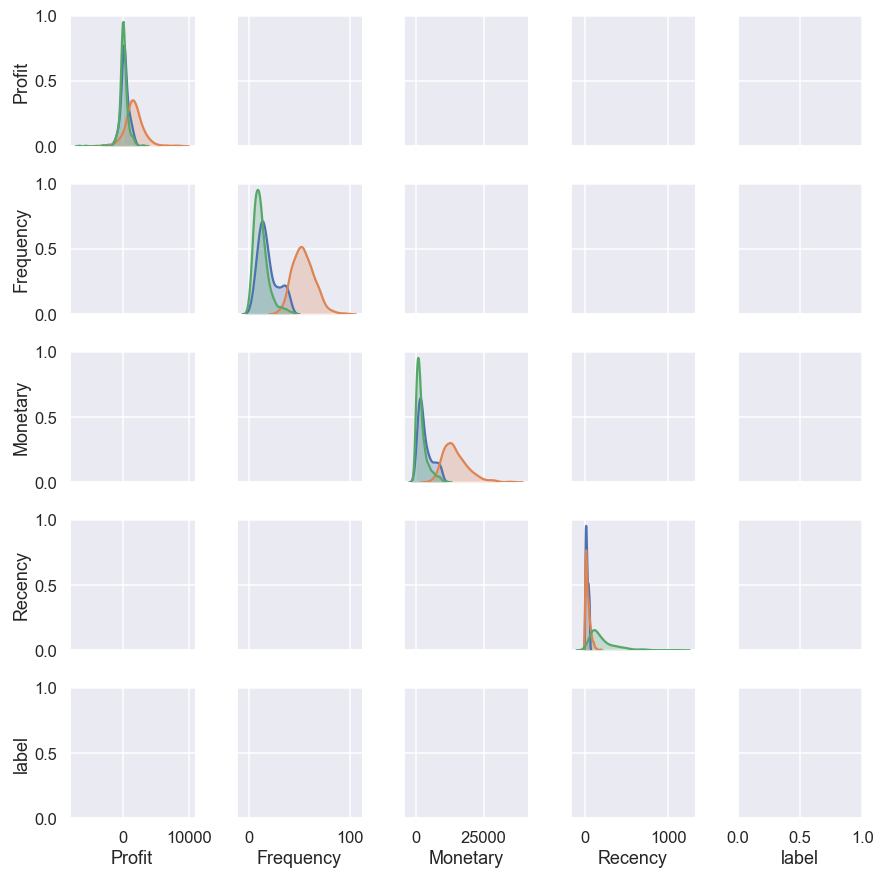

In [66]:
sns.pairplot(df_t[['Profit','Frequency','Monetary','Recency','label']], hue='label')
plt.show()

In [67]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=df_t.Frequency, y=df_t.Profit, hue=df_t.label)


AttributeError: 'int' object has no attribute 'view'

<Figure size 1440x720 with 0 Axes>

In [ ]:
df_t